In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception,preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = Xception(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 3144 samples, validate on 787 samples
Epoch 1/100
3144/3144 [==============================] - 50s 16ms/step - loss: 0.3298 - acc: 0.8798 - val_loss: 5.5447 - val_acc: 0.5807
Epoch 2/100
3144/3144 [==============================] - 45s 14ms/step - loss: 0.1991 - acc: 0.9323 - val_loss: 0.3324 - val_acc: 0.9250
Epoch 3/100
3144/3144 [==============================] - 46s 15ms/step - loss: 0.1503 - acc: 0.9501 - val_loss: 1.7905 - val_acc: 0.7027
Epoch 4/100
3144/3144 [==============================] - 46s 15ms/step - loss: 0.1442 - acc: 0.9526 - val_loss: 2.1071 - val_acc: 0.6455
Epoch 5/100
3144/3144 [==============================] - 45s 14ms/step - loss: 0.1168 - acc: 0.9571 - val_loss: 0.5343 - val_acc: 0.8196
Epoch 6/100
3144/3144 [==============================] - 45s 14ms/step - loss: 0.0793 - acc: 0.9742 - val_loss: 0.9594 - val_acc: 0.7802
Epoch 7/100
3144/3144 [==============================] - 45s 14ms/step - loss: 0.0684 - acc: 0.9755 - val_loss: 0.8823 - val_acc: 0

In [8]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9590


In [9]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

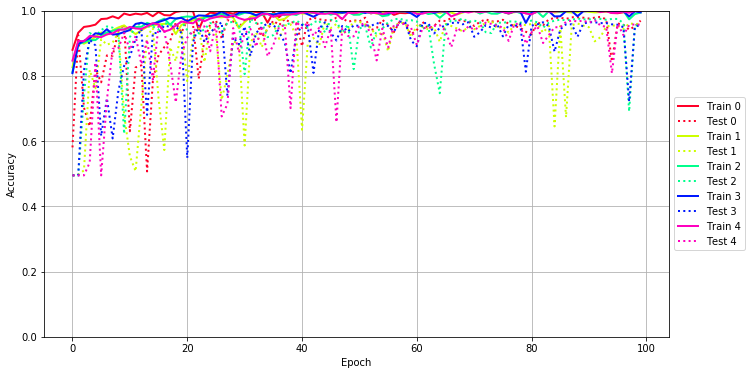

In [10]:
plot_acc(history)

In [11]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

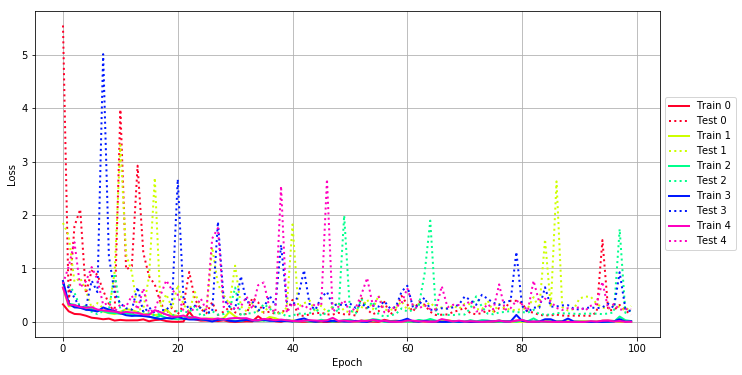

In [12]:
plot_loss(history)

Plotting the confusion matrix


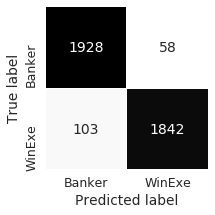

In [13]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


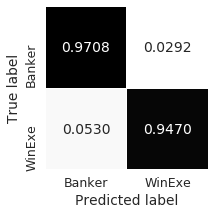

In [14]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1,keepdims=True)  # Normalizing the confusion matrix

figure = plt.gcf()
figure.set_size_inches(5, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.4f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [15]:
for h in history:
    print(h.history)

{'val_acc': [0.5806861499364676, 0.925031766730918, 0.7026683608640406, 0.6454891994917408, 0.8195679796696315, 0.7801778907242694, 0.8627700127064803, 0.8614993646759848, 0.9377382465057179, 0.9580686149936467, 0.6302414231257941, 0.8259212198221093, 0.832274459974587, 0.5069885641677255, 0.7827191867852605, 0.8640406607369758, 0.8881829733163914, 0.9059720457433291, 0.963151207115629, 0.9326556543837357, 0.9720457433290979, 0.9580686149936467, 0.7916137229987293, 0.9123252864259626, 0.9580686149936467, 0.9707750952986023, 0.9148665819567979, 0.9707750952986023, 0.9669631512071156, 0.9504447268106735, 0.9682337992376112, 0.9733163913595934, 0.9720457433290979, 0.9199491740787802, 0.9428208391578558, 0.9695044472681067, 0.9555273189326556, 0.9745870399202446, 0.963151207115629, 0.96569250317662, 0.8907242693773825, 0.9707750952986023, 0.9783989834815756, 0.9733163913595934, 0.9707750952986023, 0.9695044472681067, 0.9783989834815756, 0.97712833545108, 0.96569250317662, 0.970775095298602

In [16]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

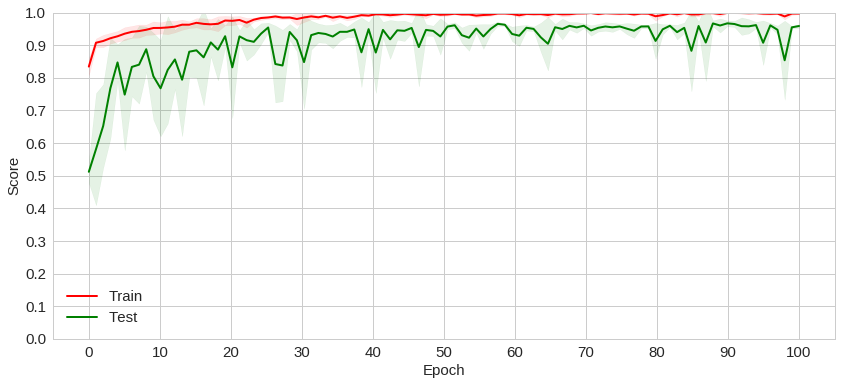

In [17]:
plot_mean_acc(history)

In [18]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

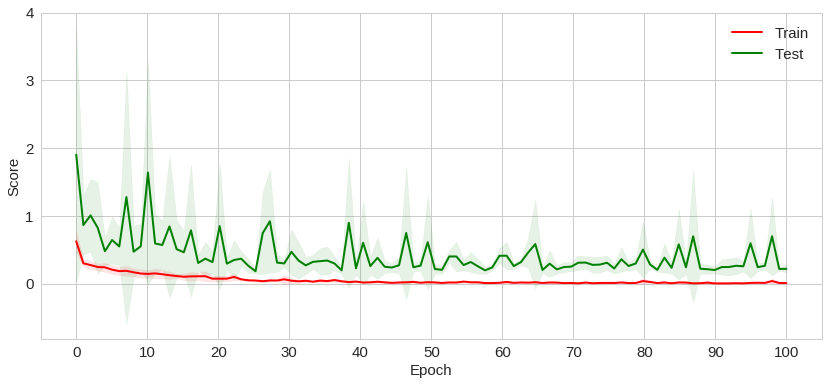

In [19]:
plot_mean_loss(history)

In [10]:
hist = [{'val_acc': [0.5806861499364676, 0.925031766730918, 0.7026683608640406, 0.6454891994917408, 0.8195679796696315, 0.7801778907242694, 0.8627700127064803, 0.8614993646759848, 0.9377382465057179, 0.9580686149936467, 0.6302414231257941, 0.8259212198221093, 0.832274459974587, 0.5069885641677255, 0.7827191867852605, 0.8640406607369758, 0.8881829733163914, 0.9059720457433291, 0.963151207115629, 0.9326556543837357, 0.9720457433290979, 0.9580686149936467, 0.7916137229987293, 0.9123252864259626, 0.9580686149936467, 0.9707750952986023, 0.9148665819567979, 0.9707750952986023, 0.9669631512071156, 0.9504447268106735, 0.9682337992376112, 0.9733163913595934, 0.9720457433290979, 0.9199491740787802, 0.9428208391578558, 0.9695044472681067, 0.9555273189326556, 0.9745870399202446, 0.963151207115629, 0.96569250317662, 0.8907242693773825, 0.9707750952986023, 0.9783989834815756, 0.9733163913595934, 0.9707750952986023, 0.9695044472681067, 0.9783989834815756, 0.97712833545108, 0.96569250317662, 0.9707750952986023, 0.9669631512071156, 0.9783989834815756, 0.940279542566709, 0.9466327827191868, 0.9720457433290979, 0.9555273189326556, 0.9339263024142312, 0.96569250317662, 0.9593392630241423, 0.9275730633220648, 0.940279542566709, 0.96569250317662, 0.9453621346886912, 0.9529860234018203, 0.9695044472681067, 0.9682337992376112, 0.97712833545108, 0.9720457433290979, 0.9682337992376112, 0.9669631512071156, 0.9529860228716646, 0.96569250317662, 0.9733163913595934, 0.9669631512071156, 0.9669631512071156, 0.9720457433290979, 0.9593392630241423, 0.9529860228716646, 0.9479034307496823, 0.9351969504447268, 0.9275730622617535, 0.9644218551461246, 0.9555273189326556, 0.9733163913595934, 0.97712833545108, 0.9783989834815756, 0.974587039390089, 0.9796696315120712, 0.9796696315120712, 0.9783989834815756, 0.9758576874205845, 0.9783989834815756, 0.9809402795425667, 0.9733163913595934, 0.8437102927792027, 0.9606099115847936, 0.9567979669631512, 0.9415501905972046, 0.951715374841169, 0.9695044472681067], 'loss': [0.3298499207877324, 0.19907159551636863, 0.150277155425409, 0.14421352054023256, 0.11678707944205548, 0.0792666602780232, 0.06844613951353626, 0.0507277004520288, 0.06276143768342549, 0.026373267320693297, 0.038874150959137384, 0.029811140380292638, 0.030596763940433837, 0.03143194300162845, 0.048684379759507665, 0.013057298468053815, 0.0353883515720024, 0.043092449538115855, 0.016535499924379127, 0.0052072999242227525, 0.002786758479788467, 0.008569534290484373, 0.1923532026082884, 0.04996678003633712, 0.024841613006486577, 0.0264069070283006, 0.027858711284111787, 0.016824901289963896, 0.029749259458435345, 0.006414957489106957, 0.001350689890942419, 0.005905787295260263, 0.012898890421518159, 0.009909405264397372, 0.10724358623407475, 0.02653861951403457, 0.06992805413943277, 0.013807251108051977, 0.003598272024232328, 0.03601945178239943, 0.01339079423467702, 0.0038777647029952698, 0.0032820627890245394, 0.004942463890511968, 0.0016514766796604198, 0.0006002865371445171, 0.00028223729889530745, 0.00035774948757520843, 0.0018855954820580403, 0.029023283631818175, 0.01676276356861644, 0.003416042965678159, 0.028705147239303307, 0.008485771916812919, 0.005533548109952459, 0.002012880953007248, 0.040383011490764495, 0.016469360157920276, 0.022678153371394616, 0.015296795133524766, 0.014390700711258515, 0.004747317808025178, 0.025382443315000867, 0.006272662157116475, 0.009842261856700611, 0.001741080466417863, 0.005618266581070257, 0.001873180983840555, 0.0039669755764310255, 0.013736207981168976, 0.00307217987865535, 0.0002787775989043823, 0.00017745155182973538, 0.003874424247513962, 0.0036133158411177395, 0.0005368809837605935, 0.0025181499601022498, 0.011941439033829548, 0.009028022395241305, 0.025768411092287755, 0.030948887450359293, 0.00822362320553692, 0.004066711683170084, 0.0011374040420445263, 0.0002636634830984269, 0.00017094137458900692, 0.0005521956767687856, 7.70993498082521e-05, 4.727101655015719e-05, 8.800593561813484e-05, 3.283642541685601e-05, 4.9523889371017465e-05, 4.034814181544946e-05, 0.002671705541893663, 0.025769527043194587, 0.027740045895257314, 0.018844118319789382, 0.009065907915635567, 0.001560182828927823, 0.001827346931727114], 'val_loss': [5.544669531149373, 0.3324238529856041, 1.7904571228941428, 2.1070853229926, 0.5343036842970308, 0.9594041338787157, 0.8822639725081772, 0.5882902351826941, 0.33805954673698346, 0.17441389800136342, 3.971390197661902, 0.9823421780307454, 1.0423723470734934, 2.9220722468948814, 1.2939900134216518, 0.8524815258629971, 0.6998709457678829, 0.3594135237843499, 0.16538184205498524, 0.2686739430302491, 0.14293974480314212, 0.3149871234787957, 0.9351679481472063, 0.4208187633199946, 0.24261834891076617, 0.16227591606615488, 0.37190953869971843, 0.13080293620585107, 0.19270692477899154, 0.2712878366678807, 0.17896956991186255, 0.14080201232364445, 0.14915415704699614, 0.4544398159525078, 0.36895358625407904, 0.17289450983803842, 0.19096185412083952, 0.15119883085315836, 0.20229480417801501, 0.202339523688451, 0.41347179108987453, 0.12124769397069886, 0.11386445499104572, 0.14258913211007865, 0.16295083752708164, 0.17351694000188025, 0.14105384208065525, 0.13780988215844844, 0.171287519491622, 0.14336739795142253, 0.14281368484472298, 0.11970715752202667, 0.4562290511079507, 0.22895141682700576, 0.14427021028436401, 0.1965961086206828, 0.37639422123140676, 0.13828978005807321, 0.22977680800031614, 0.4881841801027063, 0.3288617878465936, 0.1925820597811937, 0.38454793763402517, 0.3219341321125286, 0.19031836301357702, 0.12973205031344273, 0.13597161295732632, 0.1409556712154086, 0.18802653697705113, 0.21837424361060637, 0.2719547610560635, 0.16176070110007632, 0.14409849731079416, 0.16698359271432742, 0.21778443883226567, 0.18638265915342228, 0.25805392579247716, 0.24876130994225826, 0.39672835921060506, 0.3956874319253989, 0.34834660148411384, 0.1913550747736421, 0.17600193689473737, 0.13159073708020388, 0.12356172903148598, 0.1235136063477312, 0.13673098865121938, 0.1210992533472169, 0.11544021963481489, 0.11798452515254333, 0.11883922593276182, 0.11738683814268673, 0.11496757551385495, 0.18371542160562862, 1.5312730600333782, 0.22101036444607544, 0.2210745111939449, 0.31802206125601995, 0.2159175104107335, 0.13678053788986252], 'acc': [0.8797709923664122, 0.9322519083969466, 0.9500636132315522, 0.9526081424936387, 0.9570610687022901, 0.9742366412213741, 0.9755089058524173, 0.9825063613231552, 0.976145038167939, 0.9910941475826972, 0.986323155216285, 0.9907760814249363, 0.9882315521628499, 0.9930025445292621, 0.982824427480916, 0.9958651399491094, 0.986323155216285, 0.9853689567430025, 0.9958651399491094, 0.9987277353689568, 0.9984096692111959, 0.9980916030534351, 0.9414758269720102, 0.9821882951653944, 0.9936386768447837, 0.9920483460559797, 0.9904580152671756, 0.9939567430025446, 0.9907760814249363, 0.9987277353689568, 1.0, 0.9987277353689568, 0.9955470737913485, 0.9949109414758269, 0.9631043256997456, 0.9958651399491094, 0.9799618320610687, 0.9952290076335878, 0.9990458015267175, 0.9888676844783715, 0.9974554707379135, 0.9990458015267175, 0.9993638676844784, 0.9980916030534351, 1.0, 1.0, 1.0, 1.0, 0.9993638676844784, 0.9920483460559797, 0.9945928753180662, 0.9993638676844784, 0.9914122137404581, 0.9961832061068703, 0.9980916030534351, 0.9993638676844784, 0.9869592875318066, 0.9930025445292621, 0.9920483460559797, 0.9942748091603053, 0.9958651399491094, 0.9987277353689568, 0.9933206106870229, 0.9987277353689568, 0.9974554707379135, 0.9990458015267175, 0.9990458015267175, 0.9993638676844784, 0.9987277353689568, 0.9958651399491094, 0.9990458015267175, 1.0, 1.0, 0.9987277353689568, 0.9993638676844784, 1.0, 0.9993638676844784, 0.9955470737913485, 0.996501272264631, 0.9920483460559797, 0.9910941475826972, 0.996501272264631, 0.9984096692111959, 0.9996819338422391, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9990458015267175, 0.9926844783715013, 0.9920483460559797, 0.9949109414758269, 0.9958651399491094, 0.9996819338422391, 0.9993638676844784]},
{'val_acc': [0.494910941475827, 0.49745547073791346, 0.510178117048346, 0.8180661577608143, 0.7620865139949109, 0.9122137398513522, 0.8956742996477899, 0.9020356228030062, 0.9325699739480443, 0.6819338423908515, 0.5534351145038168, 0.5076335877862596, 0.7099236647288004, 0.9211195943919757, 0.9465648848895202, 0.7302798994321557, 0.5725190839884239, 0.8880407126198592, 0.8447837147093912, 0.9414758269720102, 0.7837150127226463, 0.9185750645232261, 0.9503816787826499, 0.8422391857506362, 0.9503816787826499, 0.927480917547192, 0.7264631047806971, 0.8027989821882952, 0.9058524188194567, 0.8982188289098764, 0.5865139949109415, 0.9007633587786259, 0.9338422391857506, 0.8880407124681934, 0.9516539440203562, 0.9605597958309959, 0.9134860066057161, 0.9541984726757797, 0.9580152665689095, 0.9236641221374046, 0.6348600508905853, 0.9007633587786259, 0.916030534351145, 0.8931297709923665, 0.965648854355169, 0.9465648854961832, 0.9592875311999527, 0.9287531806615776, 0.9389312971032606, 0.9669211189862122, 0.965648854355169, 0.9580152665689095, 0.9465648848895202, 0.9211195928753181, 0.9351145038167938, 0.8753180663094265, 0.9516539434136931, 0.9631043250930825, 0.9618320610687023, 0.9185750636132316, 0.9541984726757797, 0.9503816787826499, 0.9427480909963903, 0.9491094141516067, 0.9045801534300846, 0.9592875311999527, 0.9529262088030652, 0.94529262086514, 0.9363867693578317, 0.9503816787826499, 0.9427480909963903, 0.9529262080447365, 0.9618320604620393, 0.9694656482482987, 0.9452926202584769, 0.9516539455370139, 0.9325699747063732, 0.9567430019378662, 0.9580152671755725, 0.955470737913486, 0.9592875318066157, 0.9592875311999527, 0.9325699747063732, 0.9529262080447365, 0.6450381679389313, 0.9529262080447365, 0.6730279898218829, 0.955470737306823, 0.9605597958309959, 0.9541984726757797, 0.9491094141516067, 0.9058524176061306, 0.9185750636132316, 0.9516539434136931, 0.9541984726757797, 0.9541984726757797, 0.9440203556274337, 0.960559796437659, 0.9592875318066157, 0.9592875311999527], 'loss': [0.6429353267143944, 0.29314618606019666, 0.30485364810840504, 0.2730371788688987, 0.289417115256593, 0.2106716986206643, 0.21585842097009308, 0.19691909630982787, 0.16538984052280176, 0.14734969222488767, 0.1915957289488782, 0.2387270966849759, 0.22451076323732094, 0.18439924042251418, 0.14120166323522315, 0.1566124141657509, 0.12908924072270173, 0.13966769929679143, 0.2373203598922311, 0.1327419815741965, 0.11228492275614807, 0.11196966022030941, 0.07845987135541457, 0.06083228483156483, 0.05446322714930825, 0.06438101855016333, 0.06559378649204353, 0.04886602032544692, 0.07059892208651537, 0.18908465355397788, 0.10311394551967305, 0.05155708706209996, 0.037782497853869855, 0.03684641485278671, 0.02304111740630363, 0.032453747153717474, 0.09380544928392612, 0.07123803635163378, 0.026994857555166455, 0.02329648133272539, 0.027836642042246597, 0.02804698903551873, 0.023503553156780942, 0.027661023639053303, 0.011787490176487808, 0.008841179899089571, 0.03410388809582145, 0.02387443627238226, 0.011569576156474165, 0.0080348144244108, 0.013641681130140774, 0.006198140769228576, 0.010503830714056844, 0.032746655839741144, 0.017994654238141113, 0.022023866731367726, 0.011513100694072846, 0.005347722899172431, 0.0038566141182992428, 0.0044102702001898855, 0.015468137420685492, 0.007690125897331297, 0.005633117086225373, 0.012011127350652007, 0.022070151324921017, 0.006886088458640909, 0.01711981325173034, 0.0374323857055173, 0.01358656463715202, 0.004078825685171657, 0.005231934173302877, 0.021950128568705724, 0.004916219570422085, 0.005069634713113511, 0.0028084983038386578, 0.011102235200652958, 0.02770624886927993, 0.010979244583108668, 0.0017122726609376036, 0.0017361592612542443, 0.0030381598473766553, 0.0045514960709367195, 0.003841602478742596, 0.000996806236030793, 0.023123825589359246, 0.010547705649033763, 0.010761194719879023, 0.014699828954223271, 0.009383471112124137, 0.004857029064140119, 0.012487698678433079, 0.013989966202407434, 0.011330119044751681, 0.007801894239181081, 0.0028248990139167615, 0.005687786237172113, 0.012298187627400634, 0.00862800566814466, 0.004307719615877975, 0.002680796648501822], 'val_loss': [1.8522703970472019, 1.6122926341810526, 0.7487242552463639, 0.8228945185930371, 0.586308495480444, 0.2637854202747648, 0.3538205436319492, 0.2570119654480131, 0.20265418139426156, 0.9373565154391845, 3.3086243957901993, 1.263380882925053, 0.9294096003535367, 0.2271797624783965, 0.24968513577664628, 0.8500676547952053, 2.695763012564933, 0.2831615597464656, 0.5200190789826954, 0.26407314272971855, 0.6928901860997574, 0.3206024059567259, 0.20368823173998574, 0.5601662212250216, 0.2508578500546024, 0.21836781107439035, 1.3976731990393976, 0.701279429538749, 0.5043782139061914, 0.336935784639293, 1.052982299723698, 0.291823428612956, 0.19929833379372688, 0.3583511127770402, 0.18407224268479505, 0.18638437124722787, 0.2939505253778652, 0.18376094064943058, 0.1385935665210164, 0.27638153587503517, 1.8231143643943304, 0.28338591176921707, 0.35049603578741795, 0.39976816505273544, 0.18327820699652492, 0.3049906614247938, 0.18166789229907115, 0.2958969331022681, 0.3547241440155677, 0.2063415286548284, 0.18174152087856263, 0.2102842473308852, 0.25931138047976915, 0.4191552959258121, 0.2367524015338044, 0.4974820072951954, 0.22853672095068195, 0.2231896625353028, 0.2592114575046385, 0.3887590730894427, 0.22557046062593838, 0.3130464709632181, 0.3344982834481481, 0.3013188364430736, 0.36298289397404393, 0.25173805528865423, 0.27126815590448206, 0.24809980830390946, 0.30876939294565914, 0.24544854410011652, 0.3404007412445981, 0.3320374617737578, 0.2413353284929924, 0.23174773598250958, 0.39901164445894305, 0.1900487527364993, 0.3365308310097183, 0.2576771298035062, 0.2282023488178982, 0.22053983820953024, 0.2458970931906054, 0.25446152324156135, 0.4640524213624979, 0.25590862602981296, 1.5449071265391412, 0.27363508830733274, 2.6288970223030548, 0.2784737351115913, 0.21387604144064154, 0.2405839748206636, 0.4375276085546142, 0.47647932231310414, 0.46769022735523313, 0.34001033434133693, 0.27088913779341284, 0.24983707049141138, 0.3113686540022052, 0.2783013211249954, 0.211856855182617, 0.2976535075858468], 'acc': [0.8267090621927016, 0.9052464228934817, 0.898569157411639, 0.9074721780983177, 0.9195548489666137, 0.9329093799682034, 0.9268680445151033, 0.939904610511798, 0.9484896661367249, 0.9548489666326246, 0.9408585055643879, 0.9281399046673494, 0.9395866455069027, 0.9503974563366658, 0.9545310016087774, 0.9577106518282988, 0.9596184421609051, 0.9589825119236884, 0.9284578696343402, 0.9564387917518615, 0.9631160572337043, 0.9707472178060413, 0.9751987281399046, 0.9802861685214627, 0.9812400635930048, 0.9806041335453101, 0.9796502384737679, 0.9825119237073465, 0.9790143084260732, 0.9462639109697933, 0.9650238473767886, 0.9812400635930048, 0.9853736089030206, 0.9879173290937997, 0.9907790143084261, 0.9882352941176471, 0.9707472178060413, 0.9748807631160572, 0.9895071542130366, 0.9942766295707473, 0.9910969793322735, 0.9910969793322735, 0.9936406995420046, 0.9907790143084261, 0.9965023847376788, 0.9987281399046105, 0.9895071542130366, 0.9930047694753578, 0.9958664546899841, 0.9977742448330683, 0.9952305246422893, 0.9977742448330683, 0.9968203497615262, 0.9904610493035308, 0.9942766295707473, 0.9926868044515104, 0.9952305246422893, 0.997456279809221, 0.9990461049284579, 0.9984101748807631, 0.9949125596184419, 0.9965023847376788, 0.9980922098569157, 0.9965023847376788, 0.992368839427663, 0.9980922098569157, 0.9939586645468999, 0.9882352941176471, 0.9942766295707473, 0.9987281399046105, 0.9980922098569157, 0.993322734499205, 0.9984101748807631, 0.9987281399046105, 0.9987281399046105, 0.9958664546899841, 0.9907790143084261, 0.9955484896661367, 0.9996820349761526, 0.9996820349761526, 0.9990461049284579, 0.9987281399046105, 0.9984101748807631, 0.9996820349761526, 0.9942766295707473, 0.9961844197138314, 0.9958664546899841, 0.9942766295707473, 0.9955484896661367, 0.9984101748807631, 0.9965023847376788, 0.9945945945945946, 0.9955484896661367, 0.9965023847376788, 0.9990461049284579, 0.9980922100464377, 0.9955484896661367, 0.9968203497615262, 0.9987281399046105, 0.9990461049663623]},
{'val_acc': [0.494910941475827, 0.494910941475827, 0.7379134860050891, 0.9312977099236641, 0.9211195928753181, 0.9402035630992958, 0.9516539440203562, 0.9478371501272265, 0.9287531806615776, 0.6221374045801527, 0.9185750636132316, 0.9541984732824428, 0.960559796437659, 0.9516539440203562, 0.951653944778685, 0.9414758269720102, 0.9618320610687023, 0.9580152671755725, 0.9541984732824428, 0.9669211195928753, 0.9402035623409669, 0.9211195928753181, 0.9312977100753299, 0.942748092513048, 0.9618320610687023, 0.9592875311999527, 0.9312977099236641, 0.9631043256997456, 0.9656488549618321, 0.9592875318066157, 0.8053435114503816, 0.9758269720101781, 0.9618320625853599, 0.9618320610687023, 0.9185750637648973, 0.9249363867684478, 0.9529262086513995, 0.955470737913486, 0.9618320610687023, 0.9694656488549618, 0.9592875318066157, 0.9478371501272265, 0.9643765903307888, 0.9694656488549618, 0.9325699745547074, 0.9720101781170484, 0.9681933842239185, 0.9312977108336588, 0.9580152671755725, 0.8206106870229007, 0.9452926223817976, 0.9529262094097283, 0.8867684487471447, 0.9389312971032606, 0.94529262086514, 0.9643765897241258, 0.9732824427480916, 0.9758269720101781, 0.9694656488549618, 0.9707379134860051, 0.9669211195928753, 0.9440203562340967, 0.9541984732824428, 0.8371501272264631, 0.7468193384223919, 0.955470737913486, 0.9694656488549618, 0.9694656488549618, 0.9758269720101781, 0.9656488549618321, 0.9694656488549618, 0.9643765903307888, 0.9338422391857506, 0.9312977108336588, 0.9643765903307888, 0.9618320610687023, 0.9669211195928753, 0.9669211195928753, 0.9631043250930825, 0.9643765897241258, 0.9694656488549618, 0.9643765903307888, 0.9478371501272265, 0.9631043256997456, 0.9694656488549618, 0.9720101781170484, 0.9707379134860051, 0.9720101781170484, 0.9758269720101781, 0.9732824427480916, 0.9732824427480916, 0.9732824427480916, 0.9745547073791349, 0.9720101781170484, 0.9745547073791349, 0.9745547073791349, 0.9618320618270311, 0.6908396946564885, 0.955470737913486, 0.9529262094097283], 'loss': [0.7399686752707477, 0.33987896992026906, 0.3218932263043802, 0.25976305096062263, 0.29837443404645914, 0.24078637550456156, 0.20666570026658487, 0.2059174732771511, 0.1692661402714461, 0.1670572195835826, 0.15043429529060431, 0.16872437715719918, 0.1448953413426734, 0.11439328322776361, 0.12141854259376496, 0.1009036175693446, 0.07395761384730877, 0.11868284258914487, 0.0777078992990697, 0.059685145282972786, 0.05167896083048256, 0.06140157738626477, 0.09735915735482412, 0.0678442319644843, 0.051150110093891525, 0.040194156189080454, 0.02698273677451074, 0.05739318041281926, 0.03644677212414449, 0.03316050446273934, 0.02229578115034179, 0.01585613993716105, 0.04748321754646166, 0.036910636643827294, 0.03079083571815715, 0.027487902245180763, 0.029163073060740917, 0.03352491785898809, 0.02247262759854505, 0.03928622124530264, 0.010132820237633759, 0.00938336255403816, 0.023345618200338845, 0.0052279193511600855, 0.010096512304902867, 0.041738546972084546, 0.018900584765311645, 0.003462839809513617, 0.017613750675235858, 0.03293793218186094, 0.04255595834058116, 0.009345558768772003, 0.021479135655380847, 0.019756083232047115, 0.053099373283252614, 0.038933307632495945, 0.003959861788410095, 0.007303874668982087, 0.007093195337876204, 0.01342115782041011, 0.005302599754620764, 0.007065374924151104, 0.03771191651646762, 0.021856605457008738, 0.05644267196315437, 0.023550420892032513, 0.004494091354466951, 0.00254854631798256, 0.0009999733758704042, 0.000636294242798792, 0.0005716155049723795, 0.03445899636713812, 0.009921893267961706, 0.03412556518683586, 0.02738823769474423, 0.0097718190550967, 0.004407777550644337, 0.0013727953031150897, 0.019089671911451327, 0.004524851986244084, 0.028896150914530176, 0.013452056894635571, 0.06695178729307649, 0.005686646390081471, 0.0030645713832715025, 0.012765525305998662, 0.004032906537430601, 0.0010918522383651247, 0.0006703185992375007, 0.0005445320422033593, 0.0001692217929390053, 0.00021287726012063368, 0.00011166334332211983, 0.00027046405825445973, 0.00010293317850489938, 0.00017646916223806538, 0.001602799052149484, 0.10114739395963807, 0.03223141005384145, 0.01701233194687882], 'val_loss': [0.6883809935045606, 0.6900162752954712, 0.5469564393958972, 0.26905185943493104, 0.2296006503413045, 0.19174721374463186, 0.14695219168529558, 0.2028336240116118, 0.22471175349433611, 0.9089000205109169, 0.23360512024573699, 0.16777407113491125, 0.15399659121984915, 0.18006365974469266, 0.1896941069058562, 0.15687274830486939, 0.12224005964174676, 0.15604079597328646, 0.15203274470343997, 0.10076551459985607, 0.2276111488998686, 0.19198759715369032, 0.18058237508318503, 0.3004912628266654, 0.11547244300369087, 0.14112604243571825, 0.20369406361818615, 0.13544174280543705, 0.14915578021032797, 0.2117914140904879, 0.6446929061604645, 0.11628147595533604, 0.1606781284203966, 0.163296167703189, 0.2029491367396773, 0.3343383351655577, 0.25255488361990014, 0.15927476099628302, 0.1613287110128689, 0.10523773890975673, 0.11937558871152415, 0.15856567763370336, 0.15113680525481435, 0.1631547750520956, 0.26261955939598247, 0.11285040875850601, 0.17777613091169092, 0.2749453885288958, 0.18187600360106815, 1.9908141640346733, 0.21988890299919528, 0.15778957958553583, 0.43138156638564557, 0.25592069316456334, 0.3805198763820352, 0.13872143127611877, 0.10273791254088092, 0.1213324291645798, 0.14857083024110812, 0.2534567449765387, 0.1946167847583439, 0.22137685815398475, 0.3003551113495808, 0.8951188489773128, 1.8949871736709907, 0.15747970541815912, 0.13477928544875736, 0.13215231220563756, 0.12920051309022088, 0.14254325593741132, 0.13887954969336777, 0.2550006283627342, 0.4788687489129607, 0.2840419978130865, 0.1548776557578992, 0.144507438883992, 0.1774388506769205, 0.18783253547320802, 0.2049798098842746, 0.18159183001728685, 0.1845055726521504, 0.17374429426276844, 0.2274459905863224, 0.14607809069397582, 0.13850143476763774, 0.13528912404312754, 0.16837708469250406, 0.1622259264185956, 0.1589137142270557, 0.15463915807740056, 0.1500606809927295, 0.15623040856042897, 0.15539808037327799, 0.15496496602474238, 0.14669933267359553, 0.15845072302261115, 0.17980185222230513, 1.7363893397358448, 0.17035038429952248, 0.2233985338310306], 'acc': [0.8117647059581617, 0.8969793323113543, 0.903020667916072, 0.9096979332652494, 0.909697933227345, 0.9240063593004769, 0.9332273451815728, 0.9383147855631309, 0.9430842607692239, 0.9421303656597774, 0.9478537361269346, 0.9497615262700189, 0.9503974562798092, 0.9624801271860095, 0.9558028617041668, 0.967885532591415, 0.9751987281588568, 0.9567567567567568, 0.9742448330683625, 0.9796502384737679, 0.982193958664547, 0.9806041336021666, 0.9691573926868045, 0.9777424485202055, 0.9841017488076311, 0.9860095389507154, 0.989825119236884, 0.9812400635930048, 0.9872813990461049, 0.9872813990461049, 0.993322734499205, 0.9945945945945946, 0.983783783802736, 0.9869634340222575, 0.989825119236884, 0.9895071542130366, 0.9901430842607313, 0.9860095389507154, 0.9904610492845787, 0.9866454689984102, 0.9961844197138314, 0.9971383149748956, 0.9926868044515104, 0.9987281399046105, 0.9968203497615262, 0.9875993640699523, 0.9930047694753578, 0.9993640699523052, 0.9958664546899841, 0.9872813990461049, 0.9875993640699523, 0.9965023847376788, 0.992368839427663, 0.9939586645468999, 0.982829888750146, 0.985691573926868, 0.9990461049284579, 0.9987281399046105, 0.9977742448330683, 0.9952305246422893, 0.9980922098569157, 0.9977742448330683, 0.9895071542130366, 0.9926868044894147, 0.978060413354531, 0.9926868044515104, 0.9990461049284579, 0.9996820349761526, 1.0, 1.0, 1.0, 0.9910969793322735, 0.9971383147853736, 0.990779014497948, 0.9904610492845787, 0.9971383147853736, 0.9987281399046105, 0.9996820349951048, 0.992368839427663, 0.9987281400941325, 0.9901430844502532, 0.9968203497994306, 0.9806041335453101, 0.9984101748807631, 0.9990461049474101, 0.9958664546899841, 0.9990461049284579, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9996820351656746, 0.9732909379968203, 0.9895071542130366, 0.9942766295707473]},
{'val_acc': [0.494910941475827, 0.494910941475827, 0.816793892523108, 0.910941475220309, 0.8931297703857034, 0.6157760808182733, 0.7315521622432097, 0.6081424930320138, 0.7544529262086515, 0.8307888046779098, 0.8587786271675246, 0.9134860055440558, 0.9440203577507543, 0.6806615770014794, 0.9312977108336588, 0.9312977093170011, 0.9541984747991004, 0.9503816809059706, 0.9516539434136931, 0.9312977114403217, 0.5483460553729808, 0.9020356249263268, 0.9541984747991004, 0.903307888344044, 0.9312977102269957, 0.9516539449303508, 0.9643765918474464, 0.7391857521527899, 0.9185750633099, 0.8969465657954908, 0.9516539455370139, 0.8613231546096219, 0.9312977114403217, 0.9503816809059706, 0.9605597958309959, 0.9567430040611868, 0.9338422385790875, 0.9020356238646665, 0.8078880407124682, 0.9223918568996983, 0.9567430040611868, 0.9529262101680571, 0.8091603057985087, 0.9452926223817976, 0.9643765918474464, 0.9325699748580389, 0.908396946868217, 0.9529262101680571, 0.9351145053334515, 0.9554707394301436, 0.9529262101680571, 0.9554707388234805, 0.9529262095613941, 0.9618320625853599, 0.9580152673272383, 0.9529262095613941, 0.9351145032101308, 0.966921121109533, 0.9631043272164032, 0.9083969476265459, 0.8905852411236168, 0.9618320625853599, 0.9618320625853599, 0.9300254462026154, 0.9465648864061778, 0.9554707394301436, 0.9618320625853599, 0.9643765918474464, 0.9580152665689095, 0.9643765918474464, 0.9198473297609324, 0.9338422407024083, 0.9554707394301436, 0.947837151643884, 0.9580152665689095, 0.9211195943919757, 0.9567430040611868, 0.9516539455370139, 0.9605597979543167, 0.8129770986299781, 0.9541984747991004, 0.9580152686922302, 0.9643765918474464, 0.9529262101680571, 0.8740458030433752, 0.9427480931197111, 0.9580152686922302, 0.9580152686922302, 0.9198473297609324, 0.9605597979543167, 0.9643765918474464, 0.9643765918474464, 0.9618320625853599, 0.9618320625853599, 0.9580152686922302, 0.9567430019378662, 0.9491094162749274, 0.7213740451948637, 0.9503816809059706, 0.9567430040611868], 'loss': [0.7660501348763846, 0.3417563463242899, 0.27287899378941816, 0.26658156752965406, 0.22872246107729138, 0.2185607776732816, 0.19651225356826343, 0.27147151616969056, 0.23159901813407013, 0.20704885438226744, 0.16313758914392967, 0.12654868287577728, 0.11276483001314778, 0.11975107681012116, 0.11069814300309683, 0.09799735739172713, 0.07450167031096967, 0.055337354464201766, 0.07290428151718573, 0.06735063156850388, 0.09694260798501286, 0.06145531398515159, 0.0467448876874554, 0.045433227711361615, 0.05057318749525162, 0.03452933041559494, 0.00926313947838848, 0.03993254456349274, 0.051632405173726414, 0.02191460338659549, 0.011224187130259501, 0.026353192884868842, 0.03867843099410789, 0.024071464597229773, 0.02848431768268939, 0.04139198190510415, 0.021618934154483845, 0.020317510159727666, 0.015006950449506458, 0.019770301424525086, 0.009179021558968279, 0.04357892574278996, 0.06651950949245533, 0.02311816200471834, 0.004002237412190163, 0.014156222925114257, 0.012822348421048443, 0.020968083184936478, 0.014266822075905109, 0.007316150478598556, 0.00592689210909579, 0.020326432497355294, 0.0048953872287201, 0.0022440867958591223, 0.03301134491084841, 0.020864882297271237, 0.016635646995073996, 0.005631536935944338, 0.0058529242130115865, 0.024864795748249884, 0.061387938799762974, 0.011939702534691721, 0.002690125672281416, 0.022111954380063213, 0.008169918487941186, 0.006702385449283038, 0.001530493131551862, 0.0012888812234820757, 0.01037475031326954, 0.00282175077500789, 0.006090181501990274, 0.003927439538244293, 0.003184218108689691, 0.003357770798198746, 0.010835664521991077, 0.01149919651382121, 0.025411162249090975, 0.008325631728368914, 0.008170420056219286, 0.13151997286753822, 0.020509744247211373, 0.008180284259073875, 0.005338052030714208, 0.007592473609866397, 0.0506060303525706, 0.05091704794595134, 0.006480233630073658, 0.01078425578523904, 0.06396036995526712, 0.008820476516501405, 0.0038509569177622672, 0.001970553121132338, 0.0014728130899489648, 0.0011162799153913475, 0.0010988440107338024, 0.0047483711208646555, 0.009465614346102907, 0.05314043677739195, 0.006246106146460189, 0.012749146648041536], 'val_loss': [0.7110405750857055, 0.6423395166111963, 0.4500929994589197, 0.2649523927889404, 0.2746697896309481, 0.773157034268361, 0.557562177038678, 5.0081668520398415, 1.2326890024671724, 0.533922442550233, 0.34740754752479136, 0.2545952757692519, 0.22945681145609031, 0.6505534695342904, 0.17923109562304487, 0.2742961262549456, 0.1636516211255816, 0.22271259539492863, 0.22123640410023868, 0.3566276227093228, 2.6688396879653635, 0.4275706242390792, 0.22769580866682934, 0.3047266990022198, 0.26102680726209065, 0.17238823603127748, 0.19044493454681477, 1.8732812284603335, 0.4260018248818268, 0.28876344497586925, 0.23888946402789527, 0.8562934675488536, 0.3595034991540299, 0.38501788515621427, 0.2125041978658857, 0.26719282334788913, 0.49315687297528216, 0.3067121396656444, 1.440012361492933, 0.37508250685463806, 0.2976256177047358, 0.4868513267724943, 0.9673462948423002, 0.31147866052487727, 0.23007272840738202, 0.4616496306142009, 0.5620249056141299, 0.31016470500171106, 0.3309901608462249, 0.30763964109009007, 0.3452113018702637, 0.2644235714677598, 0.3414706205922157, 0.2724406738050457, 0.30396134410119846, 0.2861051896917154, 0.3874740482141494, 0.25474994047196836, 0.2790275170128916, 0.5694261532488383, 0.6778795037967076, 0.26772572687156404, 0.3131196834600196, 0.45711349697816767, 0.22810240214069685, 0.22951792270589724, 0.2571894701371211, 0.2490807051602135, 0.27483480052581727, 0.3255331122238051, 0.47699506628106797, 0.40661382760942033, 0.32022592175936604, 0.508005672999429, 0.4324952009930536, 0.35865149193895984, 0.3186742404642285, 0.3737227257266208, 0.3970000863797452, 1.3095162838653007, 0.2974611231155587, 0.18450191980891364, 0.270025636859912, 0.2645378986479591, 0.649630572362483, 0.28561751391861884, 0.2905207693278517, 0.3099302233485297, 0.31417659777939394, 0.24682172367473088, 0.23213557050973366, 0.26000560926624194, 0.2723497078486223, 0.25641168966894123, 0.27477291447605756, 0.3401365945193888, 0.2648952121774692, 0.9300729973852201, 0.24313664610992938, 0.19394951527961946], 'acc': [0.8082670906579362, 0.8969793322924021, 0.9074721780983177, 0.9151033388222723, 0.9306836249907938, 0.927821939643502, 0.9430842607313196, 0.926550079491256, 0.9284578696343402, 0.9344992050874403, 0.9405405405405406, 0.9593004771370577, 0.9627980922098569, 0.9573926869939734, 0.9602543722085998, 0.9650238473767886, 0.9710651828298887, 0.978060413354531, 0.9758346581875994, 0.977742448368588, 0.9672496025437202, 0.9771065182829889, 0.9853736089030206, 0.9844197140210005, 0.9825119236883942, 0.9875993640699523, 0.997456279809221, 0.9872813990461049, 0.9821939588540688, 0.993322734499205, 0.9958664546899841, 0.992368839427663, 0.9860095389507154, 0.9926868044515104, 0.9901430842796836, 0.9872813990650571, 0.992368839427663, 0.9936406995230525, 0.9945945945945946, 0.9939586645468999, 0.9971383147853736, 0.9888712242032462, 0.9812400635930048, 0.9910969793322735, 0.9996820349761526, 0.9965023847376788, 0.9952305246422893, 0.993322734499205, 0.9958664546899841, 0.9987281399046105, 0.9980922100464377, 0.9926868044515104, 0.9977742448330683, 0.9990461051179798, 0.989825119236884, 0.9914149443561209, 0.9958664546899841, 0.9977742450225903, 0.9980922098569157, 0.9917329093989204, 0.9806041335642622, 0.9965023847376788, 0.9996820349951048, 0.9930047694753578, 0.9977742448520206, 0.9965023847376788, 0.9996820349761526, 0.9993640699712575, 0.9958664546899841, 0.9993640699523052, 0.9987281399046105, 0.9987281399046105, 0.9984101748807631, 0.9990461049284579, 0.9971383147853736, 0.9961844197138314, 0.9914149443561209, 0.9971383147853736, 0.9987281399425149, 0.9624801271860095, 0.9942766295707473, 0.9980922098569157, 0.9987281399046105, 0.9984101748997153, 0.9821939587403556, 0.9828298887122416, 0.9980922098569157, 0.998728139961467, 0.9828298887122416, 0.9977742448330683, 0.9993640699523052, 1.0, 0.9996820349761526, 0.9996820349761526, 1.0, 0.9980922098569157, 0.9980922098948202, 0.982193958664547, 0.9980922100464377, 0.9945945945945946]},
{'val_acc': [0.494910941475827, 0.494910941475827, 0.494910941475827, 0.5343511450381679, 0.8409669211195929, 0.494910941475827, 0.7264631043256997, 0.8829516539440203, 0.8854961832061069, 0.9312977099236641, 0.8791348600508906, 0.9223918575063613, 0.8358778625954199, 0.9109414773436296, 0.7888040712468194, 0.955470737913486, 0.9376590330788804, 0.8409669211195929, 0.7188295165394402, 0.8664122140437895, 0.917302799133854, 0.9363867684478372, 0.950381679389313, 0.9516539440203562, 0.8753180661577609, 0.9631043256997456, 0.6755725190839694, 0.7137404580152672, 0.9465648854961832, 0.8715012725679626, 0.9300254452926209, 0.9440203562340967, 0.8893129770992366, 0.9529262080447365, 0.8600508905852418, 0.8944020356234097, 0.950381679389313, 0.955470737913486, 0.7010178117048346, 0.965648854355169, 0.9465648854961832, 0.9631043256997456, 0.9223918582646902, 0.9478371501272265, 0.888040712771525, 0.94529262086514, 0.6577608143631132, 0.94529262086514, 0.9223918584163558, 0.9211195928753181, 0.955470737913486, 0.9618320610687023, 0.9274809169405289, 0.8473282442748091, 0.9452926202584769, 0.8867684479888159, 0.955470737913486, 0.9567430025445293, 0.960559796437659, 0.9478371501272265, 0.8944020365334042, 0.9465648854961832, 0.9465648854961832, 0.9529262086513995, 0.955470737913486, 0.9376590338372092, 0.8880407124681934, 0.9465648854961832, 0.9351145038167938, 0.951653944778685, 0.9414758269720102, 0.9503816787826499, 0.9631043256997456, 0.9592875318066157, 0.9541984732824428, 0.9478371501272265, 0.9071246819338422, 0.9592875318066157, 0.9592875318066157, 0.898218829819871, 0.9338422399440794, 0.9529262088030652, 0.9007633587786259, 0.9249363869201136, 0.9491094147582697, 0.9491094147582697, 0.9656488549618321, 0.9694656488549618, 0.9669211195928753, 0.9694656488549618, 0.9631043256997456, 0.9707379134860051, 0.9541984741924373, 0.950381679389313, 0.8078880416224627, 0.9592875318066157, 0.9249363867684478, 0.955470737306823, 0.9580152671755725, 0.9567430034545238], 'loss': [0.6420171606995533, 0.32172252855164446, 0.316870399024071, 0.2785263168792846, 0.26622258402253185, 0.2761705015725286, 0.2326945976636984, 0.21691784981419057, 0.20348774236886036, 0.19442396461016043, 0.17036269859592942, 0.18915451816053666, 0.1777498084524667, 0.16879239520842776, 0.13719762800134044, 0.13558663289952544, 0.22033126359488608, 0.1826799310660893, 0.13954550295043588, 0.09907060038114769, 0.09947849663717757, 0.12149868149707162, 0.07709006780524559, 0.09169080975230055, 0.06328104721628046, 0.06051686355616121, 0.04897266662530068, 0.0669354552388286, 0.04067912362575152, 0.0655679416237177, 0.07413080931183644, 0.0700480721073613, 0.07058462136690112, 0.03440345611291107, 0.028904397591995888, 0.05697013639263063, 0.04546837986832624, 0.03199072209303822, 0.04528826130154307, 0.0307964860643771, 0.019272558131686077, 0.013053336889825063, 0.022566283716552185, 0.032569264494984256, 0.027477194718029705, 0.01824474705525508, 0.03113031134776333, 0.07757346637662506, 0.019114060971489107, 0.026824143769227662, 0.011446028116746955, 0.008455395827696189, 0.019560863601509482, 0.019786209990069623, 0.038603546644823065, 0.014647598099259628, 0.02446498927698783, 0.0052539748446542075, 0.0021871494363585376, 0.002348936474394843, 0.02562155058947636, 0.024485059661438335, 0.013345965458809757, 0.009994238392699403, 0.005232026949419384, 0.0074809741891775465, 0.05382457838229674, 0.03153833116394348, 0.008545384460109596, 0.02481198959869321, 0.005635249685703011, 0.01551211751586223, 0.008506506774603437, 0.002085548731356279, 0.00649739265894207, 0.012857523029825587, 0.025310921136420132, 0.007426458542986019, 0.00715702766008441, 0.022907311224141004, 0.03822030228620398, 0.005789014418436946, 0.003555534366045472, 0.008530864591032599, 0.007290888961527825, 0.003444989417718336, 0.0008494565473456345, 0.0017587317994439044, 0.0003735688146678047, 0.0004643709067437159, 0.00035160450877923726, 0.0015066599408809103, 0.01595340392337619, 0.006435092864932887, 0.020828849468854018, 0.023963885672541485, 0.008879482581264255, 0.017026549978927854, 0.0038486465821544456, 0.004087270042218271], 'val_loss': [0.7134645644945042, 1.0429299598128439, 1.4909328877281294, 0.6471036849472359, 0.7601172316051622, 1.0267792771980355, 0.7984112806940503, 0.3219462434640368, 0.3553086471087453, 0.1947208628172183, 0.3265639941371579, 0.28706607795095324, 0.4920002418065458, 0.2346056249305492, 0.6265141795372766, 0.1730303113317975, 0.24862123223415009, 0.5002467781696326, 0.778200385813618, 0.5954922149793195, 0.5080230180221879, 0.2150238282580412, 0.19266536750335425, 0.24941297872679227, 0.4402306418790086, 0.2165487828502596, 1.5598613544732423, 1.7563269080324027, 0.2787781289484964, 0.3771867961874563, 0.22654268018541143, 0.2926354613202522, 0.4761473774298571, 0.24175960986765987, 0.6874200534148854, 0.7389911261966876, 0.2532206801395465, 0.17940953485762495, 2.540921722922303, 0.16938024653837502, 0.35571329887383485, 0.24347875555808007, 0.3176081357343474, 0.2269668270366944, 0.3473073406377215, 0.3000204073623698, 2.669780191652503, 0.18927409892318814, 0.28570218151435256, 0.40563864020557255, 0.18428101155044316, 0.2643685191732733, 0.5132134950737938, 0.8232718539937931, 0.30190909362419416, 0.47160259713880887, 0.1797351270805068, 0.23895401268268512, 0.2789027470114717, 0.3495514872798182, 0.6307675650025749, 0.2967528233692453, 0.25233802624842455, 0.3145856317316369, 0.2393427026786817, 0.23594751541737383, 0.6710279503927279, 0.2756548128484774, 0.321868222073531, 0.31697378269160464, 0.3127602036385479, 0.39617334158762507, 0.1969333317974445, 0.21218551613308095, 0.33500945497983736, 0.2345070722782648, 0.7026944384411464, 0.22977760112105333, 0.2582675714253711, 0.40109490548940635, 0.32950956067283643, 0.21245042892509441, 0.7723154105402369, 0.36332462307802726, 0.435787644708861, 0.3859029383457737, 0.2625309182452417, 0.22418277851444682, 0.25784570933502915, 0.24165507041894815, 0.2806811699055804, 0.21275868349456717, 0.30445203634391305, 0.3430285500643232, 0.7528113410369737, 0.24210268396732537, 0.3372515445011111, 0.22853410881221217, 0.23913557249437659, 0.236664663955247], 'acc': [0.8467408585055644, 0.9071542130744704, 0.9062003179650239, 0.9224165342001922, 0.9205087440381559, 0.9186009539140237, 0.9271860095389507, 0.9303656599669464, 0.9411764706071875, 0.9421303658492993, 0.9500794914454838, 0.9453100158982511, 0.9440381558218138, 0.9519872813990461, 0.9615262321334196, 0.9577106520178208, 0.9354531001589825, 0.9414944356120827, 0.9545310015898251, 0.9666136724960255, 0.9634340224470735, 0.96120826709062, 0.9748807631160572, 0.9675675675865197, 0.9758346581875994, 0.9799682034976153, 0.9837837837837838, 0.978696343421178, 0.9866454691879321, 0.9767885532780937, 0.9717011128775834, 0.9758346582065516, 0.9774244833068363, 0.9891891891891892, 0.9895071542319888, 0.9809220985691574, 0.9863275039745628, 0.9882352941176471, 0.9879173290937997, 0.9907790143084261, 0.9936406995230525, 0.9961844197138314, 0.9936406995420046, 0.990779014497948, 0.9901430842607313, 0.992368839427663, 0.9891891893787111, 0.9739268680445151, 0.9939586645468999, 0.9917329093799682, 0.9961844197138314, 0.9968203497615262, 0.993322734499205, 0.9926868044515104, 0.9891891891891892, 0.994594594632499, 0.9920508744038156, 0.9990461049284579, 0.9996820349761526, 0.9987281399046105, 0.9901430842607313, 0.9907790143084261, 0.9958664546899841, 0.9968203497615262, 0.9980922098569157, 0.9980922098569157, 0.982193958664547, 0.9891891891891892, 0.9977742448520206, 0.9942766295707473, 0.9980922098569157, 0.9952305246422893, 0.9968203497615262, 0.9996820349761526, 0.997456279809221, 0.996502384756631, 0.9914149443561209, 0.9980922098569157, 0.9968203497615262, 0.991414944375073, 0.9885532591414944, 0.9984101748807631, 0.9987281399046105, 0.9968203497615262, 0.9971383147853736, 0.9980922098569157, 0.9996820349761526, 0.9993640699523052, 1.0, 1.0, 1.0, 0.9996820349761526, 0.9955484896661367, 0.9977742448330683, 0.9926868044515104, 0.993322734499205, 0.9971383147853736, 0.9936406995230525, 0.9993640699523052, 0.9990461049284579]}]

In [11]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc'])))

[0] Epoch: 92 - Max val_acc: 0.9809
[1] Epoch: 73 - Max val_acc: 0.9695
[2] Epoch: 31 - Max val_acc: 0.9758
[3] Epoch: 57 - Max val_acc: 0.9669
[4] Epoch: 91 - Max val_acc: 0.9707


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

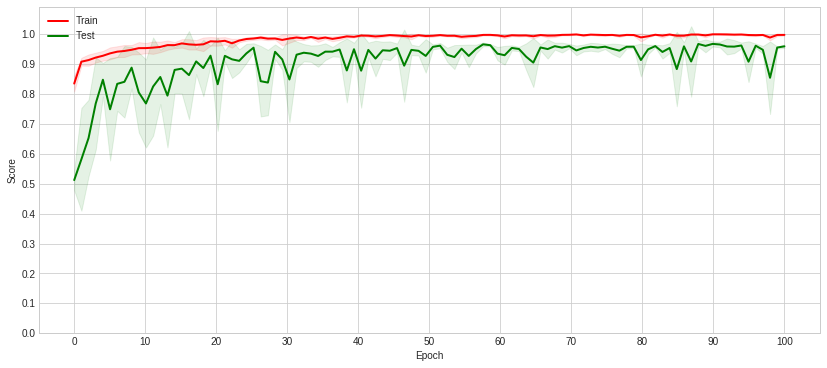

In [13]:
plot_mean_acc(hist)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

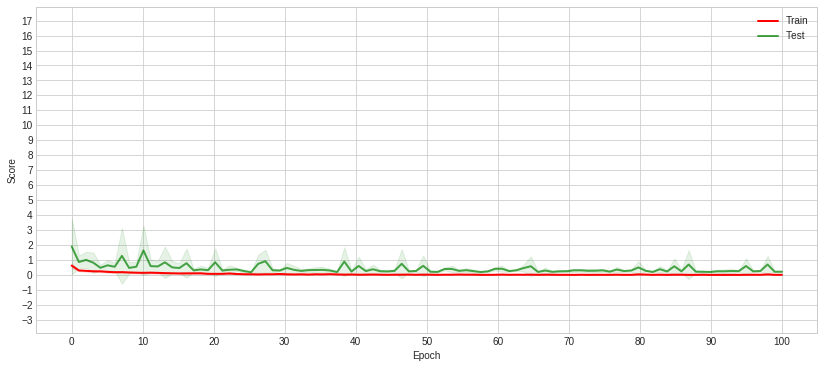

In [15]:
plot_mean_loss(hist)

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean), np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean), np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-5, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

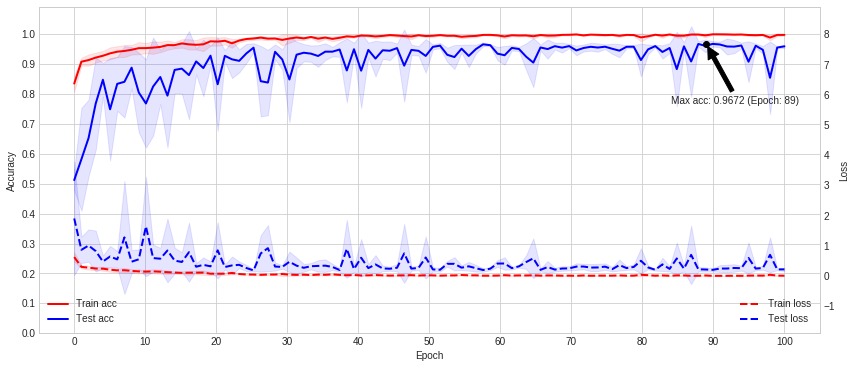

In [17]:
plot_mean(hist)